# Use `sentinel1denoise` to extract measurement and noise vectors

`sentinel1senoise` is a package developed by the Nansen Center to denoise Sentinel-1 SAR data for sea ice applications.  It also has methods to extract sigma0 and noise vectors.



In [1]:
from s1denoise import Sentinel1Image
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt

In [2]:
path = Path("/media/apbarret/andypbarrett_work/Data/ExtremeEarthPolar/Images/Original")
f = path / "S1A_EW_GRDM_1SDH_20180313T181225_20180313T181325_021000_0240E1_8163.zip"

## Loading data

Instantiate object for path

In [3]:
s1 = Sentinel1Image(str(f))  # does not use pathlib.Path

### Load sigma0 for polarization

In [4]:
pol = "HV"
min_dn = 0
sigma0 = s1.get_raw_sigma0_full_size(pol, min_dn=min_dn)

/home/apbarret/mambaforge/envs/s1denoise/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Load noise vector

There are three noise algorithms available: "ESA" loads uncorrected NESZ; "NERSC" which loads shifted noise vectors; and "NERSC-TG" which loads noise vectors corrected using total gain.

In [5]:
nesz_fs = s1.get_nesz_full_size("HV", algorithm="ESA")

### Plot images to check

Text(0.5, 1.0, 'NESZ HV')

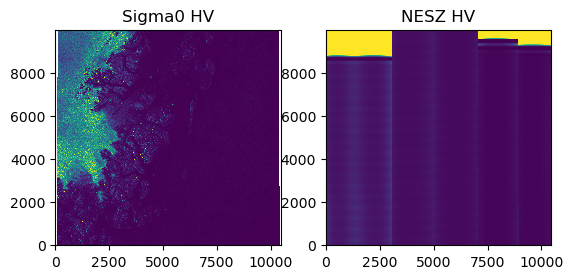

In [6]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(sigma0, interpolation="none", origin="lower", vmin=0, vmax=1.)
ax[0].set_title(f"Sigma0 {pol}")
ax[1].imshow(nesz_fs, interpolation="none", origin="lower", vmin=0, vmax=0.03)
ax[1].set_title(f"NESZ {pol}")

In [7]:
gcp = s1.geolocation(pol)
gcp.keys()

dict_keys(['azimuthTime', 'slantRangeTime', 'line', 'pixel', 'latitude', 'longitude', 'height', 'incidenceAngle', 'elevationAngle'])

In [8]:
len(gcp["line"])

21

In [9]:
len(gcp["pixel"])

21

In [10]:
gcp["latitude"].shape

(21, 21)

In [11]:
from rasterio.warp import reproject
from rasterio.control import GroundControlPoint
from rasterio.enums import Resampling

In [12]:
col, row = np.meshgrid(gcp['pixel'], gcp['line'])

In [13]:
gcps = [GroundControlPoint(c, r, x, y) for c, r, x, y in zip(col.flatten(), row.flatten(), gcp["longitude"].flatten(), gcp["latitude"].flatten())]

In [14]:
src_crs = 4326
dst_crs = 3411

In [15]:
dst_sigma0, dst_transform = reproject(
        sigma0,
        gcps=gcps,
        src_crs=src_crs,
        dst_crs=dst_crs,
        resampling=Resampling.nearest,
        dst_resolution=(40.,40.),
        dst_nodata=np.nan
    )

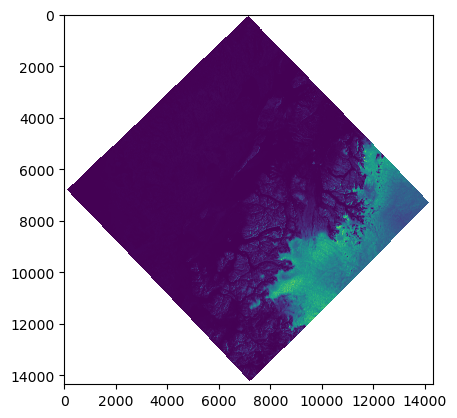

In [16]:
plt.imshow(dst_sigma0.squeeze(), vmin=0, vmax=1.)